In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import numpy as np
import os
import sys
import math
import timeit
import pickle
import scipy.io as sio
import scipy.linalg as la
import scipy.sparse as sp
import mcm_funci as mcm
import ROSsolver_e as ROS
import NNEITe as NNE

figdir = 'C:\\Users\\Yuanlong\\Documents\\YHUANG\\ML210518\\Plots\\'
# show class attribute: dir(x),vars(x)==x.__dict__
options = {
    'solver' : 2,
    'Hmin'   : 0.0e+00,
    'Hmax'   : 1.0e+01,
    'Hstart' : 1.0e-19,
    'Dmin'   : 1.0e-20,
    'FacMin' : 1.0e-01,
    'FacMax' : 1.0e+01,
    'FacSafe': 1.0e+00,
    'FacRej' : 1.0e-01,
    'AbsTol' : 1.0e-25,
    'RelTol' : 1.0e-03,
    'MaxStep': 2.0e+05,
    'eps'    : 1.0e-22,
}
ode_ros = ROS.ROSsolver(options)

with open('Verwer.pkl', 'rb') as f: # Getting back the objects:
    species,ks,rmat,pmat,smat,rRO2,iRO2 = pickle.load(f)

spec = ['ALD', 'C$_2$O$_3$', 'CH$_3$O', 'CH$_3$O$_2$', 'CO', 'CO$_2$',
        'HCHO', 'HNO$_3$', 'HO$_2$', 'N$_2$O$_5$', 'NO', 'NO$_2$',
        'NO$_3$', 'O$^{1D}$', 'O$_3$', 'O$^{3P}$', 'OH', 'PAN',
        'SO$_2$', 'SO$_4$'] # for plot legend

M = 1 # unit ppm
cvt = [1, 1] # scale
mcm_kwargs = {'ks'  : ks,
              'rmat': rmat,
              'pmat': pmat,
              'smat': smat,
              'rRO2': rRO2,
              'iRO2': iRO2,
              'M'   : M,
              'cvt' : cvt,
             } # **mcm_kwargs for call

init_C = {'NO'  : 0.200,
          'O3'  : 0.040,
          'HCHO': 0.100,
          'CO'  : 0.300,
          'ALD' : 0.010,
          'SO2' : 0.007,
         } # ppm
C0 = mcm.mcm_init(init_C,species,cvt)

RT = 60 # min
ODEfcn  = mcm.mcm_dCdt
ODEjac  = mcm.mcm_Jacob
ODEargs = mcm_kwargs

tic = timeit.default_timer()
sol_1 = ode_ros(ODEfcn,[0,RT],C0,ODEjac,ODEargs)
toc = timeit.default_timer()
print(toc-tic)
print(sol_1.ISTAT)

0.1938127999999999
{'Nfun': 304, 'Njac': 152, 'Nstp': 152, 'Nacc': 152, 'Nrej': 0, 'Ninv': 456}


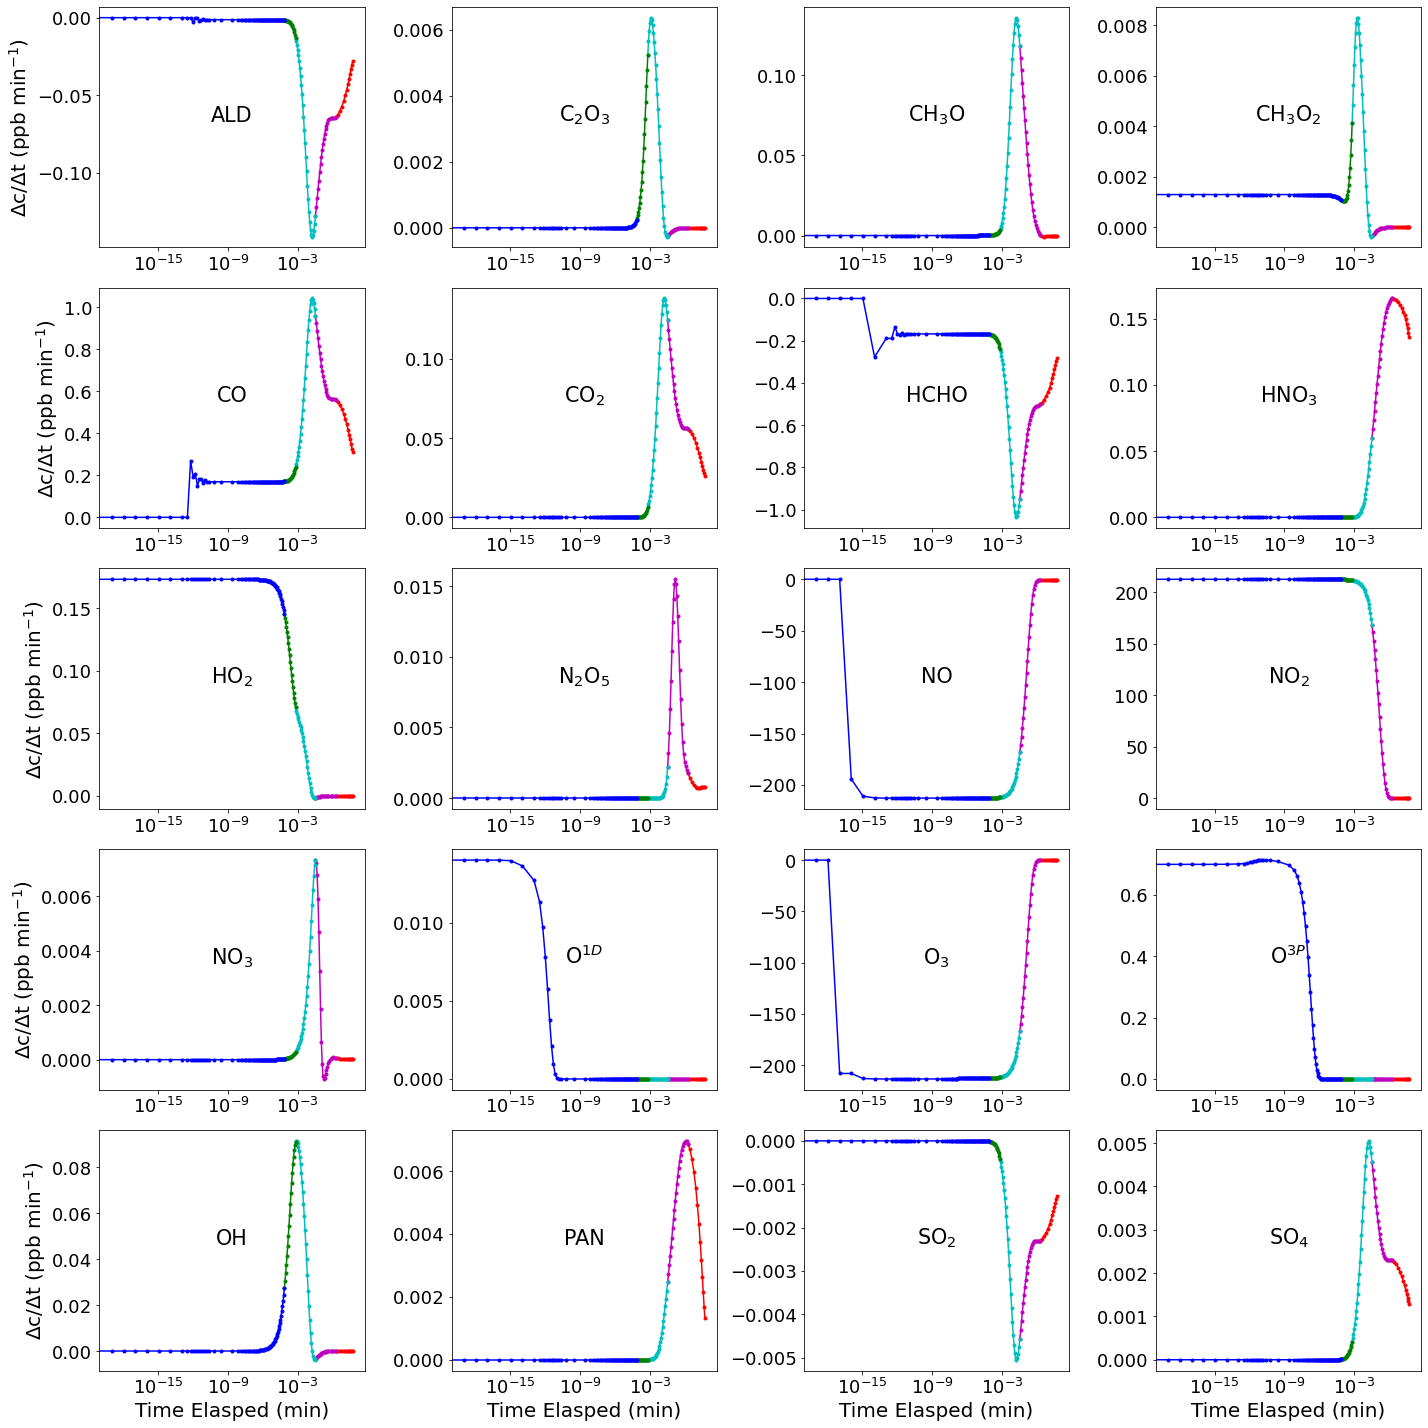

In [2]:
DcDt = np.diff(sol_1.y)/np.diff(sol_1.t)

bk = 75
dk = 92
ek = 118
fk = 140
s = len(species)
nrows,ncols = 5,4
fig = plt.figure(figsize=(20, 20))
for i in range(s):
    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.semilogx(sol_1.t[fk-1:-1],DcDt[i,fk-1:]*1e3,'r.-',label='S5')
    ax.semilogx(sol_1.t[ek-1:fk],DcDt[i,ek-1:fk]*1e3,'m.-',label='S4')
    ax.semilogx(sol_1.t[dk-1:ek],DcDt[i,dk-1:ek]*1e3,'c.-',label='S3')
    ax.semilogx(sol_1.t[bk-1:dk],DcDt[i,bk-1:dk]*1e3,'g.-',label='S2')
    ax.semilogx(sol_1.t[:bk],DcDt[i,:bk]*1e3,'b.-',label='S1')
    ax.tick_params(labelsize=18)
    if i>15: plt.xlabel('Time Elasped (min)',fontsize=20)
    if np.mod(i,4)==0: plt.ylabel('Δc/Δt (ppb min$^{-1}$)',fontsize=20)
    plt.title(spec[i],fontsize='xx-large',loc='center',y=0.5)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_dcdt_t.png',dpi=300)

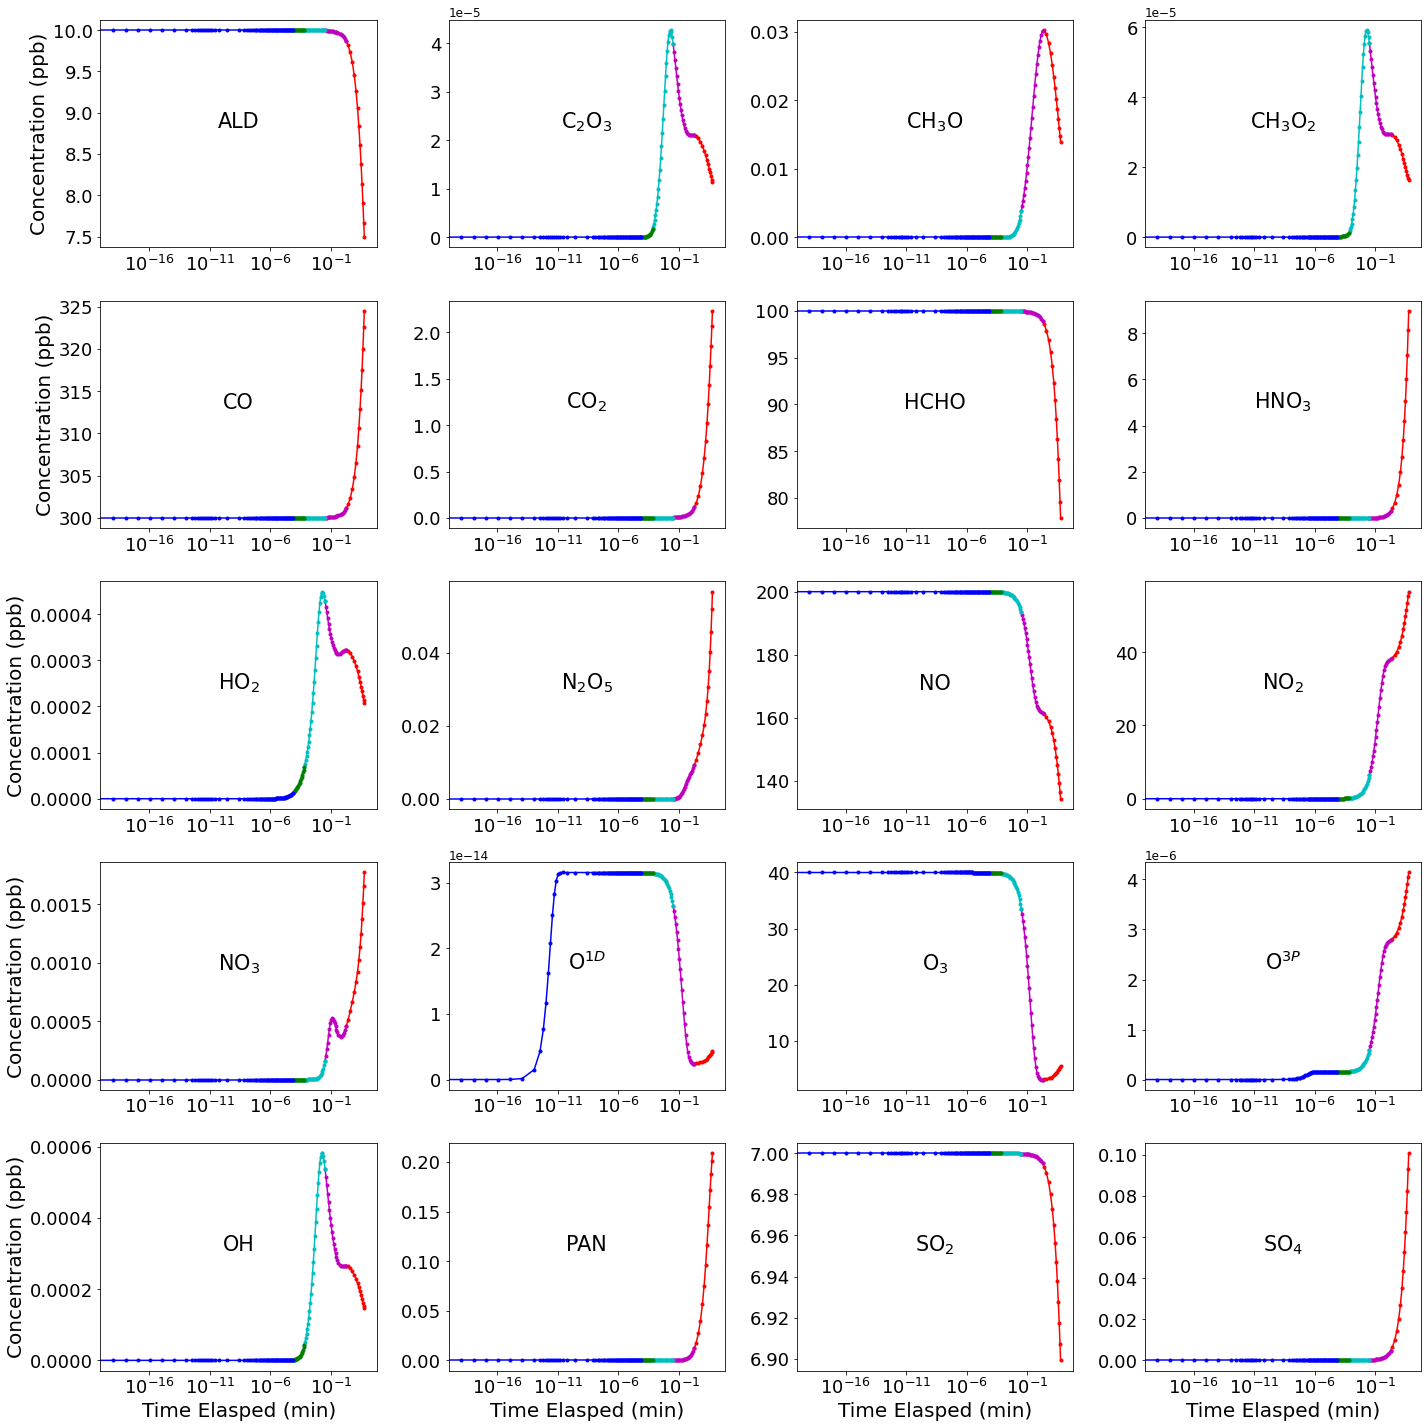

In [3]:
s = len(species)
nrows,ncols = 5,4
fig = plt.figure(figsize=(20, 20))
for i in range(s):
    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.semilogx(sol_1.t[fk-1:],sol_1.y[i,fk-1:]*1e3,'r.-',label=spec[i])
    ax.semilogx(sol_1.t[ek-1:fk],sol_1.y[i,ek-1:fk]*1e3,'m.-',label=spec[i])
    ax.semilogx(sol_1.t[dk-1:ek],sol_1.y[i,dk-1:ek]*1e3,'c.-',label=spec[i])
    ax.semilogx(sol_1.t[bk-1:dk],sol_1.y[i,bk-1:dk]*1e3,'g.-',label=spec[i])
    ax.semilogx(sol_1.t[:bk],sol_1.y[i,:bk]*1e3,'b.-',label=spec[i])
    ax.tick_params(labelsize=18)
    if i>15: plt.xlabel('Time Elasped (min)',fontsize=20)
    if np.mod(i,4)==0: plt.ylabel('Concentration (ppb)',fontsize=20)
    plt.title(spec[i],fontsize='xx-large',loc='center',y=0.5)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_conc_t.png',dpi=300)

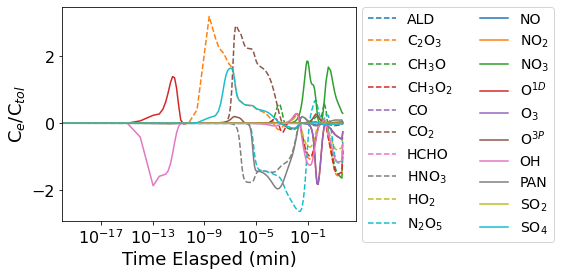

In [4]:
s = len(species)
ynor = sol_1.e
fig,ax = plt.subplots(figsize=(8, 4))
for i in range(s):
    if i>=10:
        ls = '-'
    else:
        ls = '--'
    plt.semilogx(sol_1.t[:-1],ynor[i],ls,label=spec[i])
ax.tick_params(labelsize=16)
plt.xlabel('Time Elasped (min)',fontsize=18)
plt.ylabel('C$_e$/C$_{tol}$',fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), ncol=2, loc='upper left', borderaxespad=0, fontsize=14)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_cect_t.png',dpi=300)

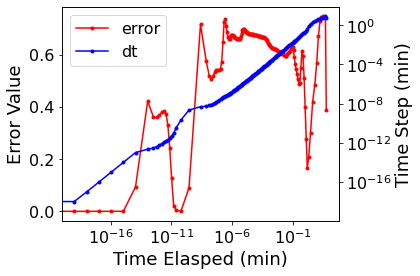

In [5]:
ynor = sol_1.e
esum = np.sum(ynor**2,0)
nerr = (esum/s)**0.5

fig, ax1 = plt.subplots()
l1, = ax1.plot(sol_1.t[:-1],nerr,'r.-')
ax1.tick_params(labelsize=16)
plt.xlabel('Time Elasped (min)',fontsize=18)
plt.ylabel('Error Value',fontsize=18)
ax2 = ax1.twinx()
l2, = ax2.loglog(sol_1.t[:-1],np.diff(sol_1.t),'b.-')
ax2.tick_params(labelsize=16)
plt.ylabel('Time Step (min)',fontsize=18)
plt.legend((l1,l2),('error','dt'),fontsize=16)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_erdt_t.png',dpi=300)

In [6]:
ct = sol_1.y[:,:bk]
dt = np.diff(sol_1.t)[:bk]
# ct = sol_1.y[:,bk-1:dk]
# dt = np.diff(sol_1.t)[bk-1:dk]
# ct = sol_1.y[:,dk-1:ek]
# dt = np.diff(sol_1.t)[dk-1:ek]
# ct = sol_1.y[:,ek-1:fk]
# dt = np.diff(sol_1.t)[ek-1:fk]
# ct = sol_1.y[:,fk:-1]
# dt = np.diff(sol_1.t)[fk:]
ft = 1
μ = 1
τ = 0.3
σ = 0.05
n = 30
Hraw = np.hstack([dt*(μ+τ*np.random.randn(len(dt)))]*n)
Craw = []
for i in range(n):
    Craw.append(ct*(μ+σ*np.random.randn(ct.shape[0],ct.shape[1])))
Craw = np.hstack(Craw)

DyDt = []
Nerr = []
Ynor = []
tic = timeit.default_timer()
for i in range(len(Hraw)):
    xx = mcm.ros3_err(Craw[:,i],Hraw[i],ODEfcn,ODEjac,ODEargs,options['RelTol'],options['AbsTol'])
    # k1,k2,k3,dydt,nerr,ynor,frac
    DyDt.append(xx[3])
    Nerr.append(xx[4])
    Ynor.append(xx[5])
DyDt = np.vstack(DyDt) # rates of change
Nerr = np.vstack(Nerr) # total error
Ynor = np.vstack(Ynor) # error vector
Hraw = np.log(Hraw) # dt in log(min)
toc = timeit.default_timer()
print(toc-tic)


1.7220786000000032


In [8]:
maxYnor = np.max(abs(Ynor))
maxDyDt = np.max(abs(DyDt),0)
aa,bb,dd,yy = Craw,Hraw,DyDt/maxDyDt,Ynor

from sklearn.model_selection import train_test_split
c_train,c_test,h_train,h_test,d_train,d_test,y_train,y_test = train_test_split(
    aa.T,bb,dd,yy,test_size=0.1,random_state=42)


In [9]:
# import the necessary packages
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,clone_model,load_model,save_model
from tensorflow.keras.layers import Dense,Input,concatenate,subtract,add,multiply,dot
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad,Adadelta
from tensorflow.keras.initializers import Initializer,Ones,Identity,Zeros
from tensorflow.keras.constraints import Constraint,NonNeg
from tensorflow.keras import losses
from tensorflow.keras import backend as K
K.set_floatx('float64')

def LOGactiv(x): # set non-positive to 1.0e-100
    y = K.relu(x)
    z = y + K.relu(-y+1.0e-100,max_value=1.0e-100)
    return K.log(z)

def LOGactiv2(x): # set <1.0e-80 to 1.0e-120
    y = K.relu(x,threshold=1.0e-80)
    z = y + K.relu(-y+1.0e-120,max_value=1.0e-120)
    return K.log(z)

def THETAactiv(x): # set <1.00017e-04 to this value
    y = x + K.relu(-x+1.00017e-04,max_value=1.00017e-04)
    z = (1-K.exp(-y))/y
    return z

def LOGNORM(x):
    y = K.log(K.abs(x))
    return y

s, r = mcm_kwargs['smat'].shape
lrw = (mcm_kwargs['pmat'] - mcm_kwargs['smat']).todense() # rxn coeff, (s,r)
lrb = LOGactiv(mcm_kwargs['ks']) # rxn rate const, ppm-1 min-1
lsw = mcm_kwargs['smat'].todense().T # stoichem coeff, (r,s)
llw = lrw.T # loss coeff, (r,s)
lpw = mcm_kwargs['pmat'].todense().T # prod coeff, (r,s)
lθw = np.vstack((np.eye(s),-np.eye(s),np.ones((1,s)))) # θ = l/c*h
plw = np.vstack((np.eye(s),-np.eye(s))) # p/l
zzx = np.eye(s)/maxDyDt
zzz = np.eye(s)*maxYnor

def initKr(shape,dtype=None): # for rxn coeff, 2nd layer
    return lrw
def initBr(shape,dtype=None): # for rxn rate const, 2nd layer
    return lrb
def initKs(shape,dtype=None): # for stoichem coeff
    return lsw
def initKl(shape,dtype=None): # for loss coeff (loss)
    return llw
def initKp(shape,dtype=None): # for prod coeff (prod)
    return lpw
def initKθ(shape,dtype=None): # to calculate θ
    return lθw
def initKf(shape,dtype=None): # to calculate p/l
    return plw
def initKzx(shape,dtype=None): # normalize DyDt to maxDyDt
    return zzx
def initKzz(shape,dtype=None):
    return zzz

logc = Dense(s,activation=LOGactiv,     kernel_initializer=Identity,use_bias=False,trainable=False) # log(c)
expr = Dense(r,activation='exponential',kernel_initializer=initKr,  bias_initializer=initBr,trainable=False) # rxn rates
stoi = Dense(s,activation='linear',     kernel_initializer=initKs,  use_bias=False,trainable=False) # rates of change
lnpd = Dense(s,activation=LOGactiv2,    kernel_initializer=initKp,  use_bias=False,trainable=False) # log(p)
lnls = Dense(s,activation=LOGactiv2,    kernel_initializer=initKl,  use_bias=False,trainable=False) # log(l)
lnpl = Dense(s,activation='tanh',       kernel_initializer=initKf,  use_bias=False,trainable=False) # tanh(log(p/l))
θfnc = Dense(s,activation='exponential',kernel_initializer=initKθ,  use_bias=False,trainable=False) # l/c*h
fθfn = Dense(s,activation=THETAactiv,   kernel_initializer=Identity,use_bias=False,trainable=False) # (1-exp(-θ))/θ
lrnm = Dense(s,activation='linear',     kernel_initializer=initKzx, use_bias=False,trainable=False) # normDyDt
θfn_ = Dense(s,activation='exponential',kernel_initializer=initKθ,  use_bias=False) # to find θcp
χfn_ = Dense(s,activation='elu',        kernel_initializer=Zeros,   use_bias=False) # to find χ
nmr1 = Dense(2*s,activation='tanh',     use_bias=False) # layer1 to find norm error vector
nmr2 = Dense(s,  activation='tanh',     use_bias=False) # layer2 to find norm error vector
nmr3 = Dense(s,  activation='linear',   kernel_initializer=initKzz, use_bias=False,trainable=False) # layer3 to return error vector

inputc = Input(shape=(s,)) # c in ppm
inputlogc = logc(inputc) # log(c), c in ppm
inputlogh = Input(shape=(1,)) # must be log(h), h in min, Δt

lyexpr0 = expr(inputlogc) # ppm min-1
deltacs = stoi(lyexpr0) # rates of change
logprod = lnpd(lyexpr0) # log(prod)
logloss = lnls(lyexpr0) # log(loss)

comblch = concatenate([logloss,inputlogc,inputlogh])
comb_pl = concatenate([logprod,logloss])
logpovl = lnpl(comb_pl) # tanh(log(prod/loss))
theta0  = θfnc(comblch) # θ
factor0 = fθfn(theta0)

theta_  = θfn_(comblch) # θcp
factor_ = fθfn(theta_)
chi_ = χfn_(logpovl) # χ
ΔyΔt = multiply([deltacs,factor0,chi_+1])
lrnorm = lrnm(ΔyΔt)
model_c = Model(inputs=[inputc,inputlogh], outputs=lrnorm)

combplθ = concatenate([logpovl,factor0])
fnmr1 = nmr1(combplθ)
fnmr2 = nmr2(fnmr1)
fnmr3 = nmr3(fnmr2)
model_r = Model(inputs=[inputc,inputlogh], outputs=fnmr3)

model_c.summary()
model_r.summary()
# plot_model(model_c, to_file=figdir+'Pmodel_c_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(model_r, to_file=figdir+'Pmodel_r_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           400         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           525         dense[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 20)           500         dense_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
epochN = 100000
opt = Adam(learning_rate=1.0e-5, decay=1.0e-3/epochN)

model_c.compile(loss='mse', optimizer=opt)
historyc = model_c.fit(x=[c_train,h_train], y=d_train,
                       validation_data=([c_test,h_test], d_test),
                       epochs=epochN, batch_size=32, verbose=0)

model_r.compile(loss='mse', optimizer=opt)
historyr = model_r.fit(x=[c_train,h_train], y=y_train,
                       validation_data=([c_test,h_test], y_test),
                       epochs=epochN, batch_size=32, verbose=0)


In [10]:
[wei9] = model_c.layers[9].get_weights()
[wei10] = model_c.layers[10].get_weights()
with open('NN_Verwer_a.pkl', 'wb') as f:
    pickle.dump([wei9,wei10], f)

[wei12] = model_r.layers[12].get_weights()
[wei13] = model_r.layers[13].get_weights()
scale = maxYnor
with open('NN_Verwer_ae.pkl', 'wb') as f:
    pickle.dump([wei12,wei13,scale], f)


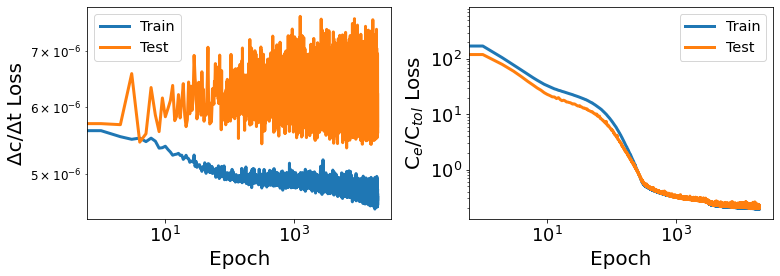

In [7]:
nrows,ncols = 1,2
fig = plt.figure(figsize=(11,4))

ax = fig.add_subplot(nrows,ncols,1)
ax.loglog(historyc.history['loss'],linewidth=3,label='Train')
ax.loglog(historyc.history['val_loss'],linewidth=3,label='Test') 
ax.tick_params(labelsize=18)
ax.set_xlabel('Epoch',fontsize=20) 
ax.set_ylabel('Δc/Δt Loss',fontsize=20) 
ax.legend(fontsize='large')

ax = fig.add_subplot(nrows,ncols,2)
ax.loglog(historyr.history['loss'],linewidth=3,label='Train')
ax.loglog(historyr.history['val_loss'],linewidth=3,label='Test') 
ax.tick_params(labelsize=18)
ax.set_xlabel('Epoch',fontsize=20) 
ax.set_ylabel('C$_e$/C$_{tol}$ Loss',fontsize=20) 
ax.legend(fontsize='large')

fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_train_epoch.png',dpi=300)

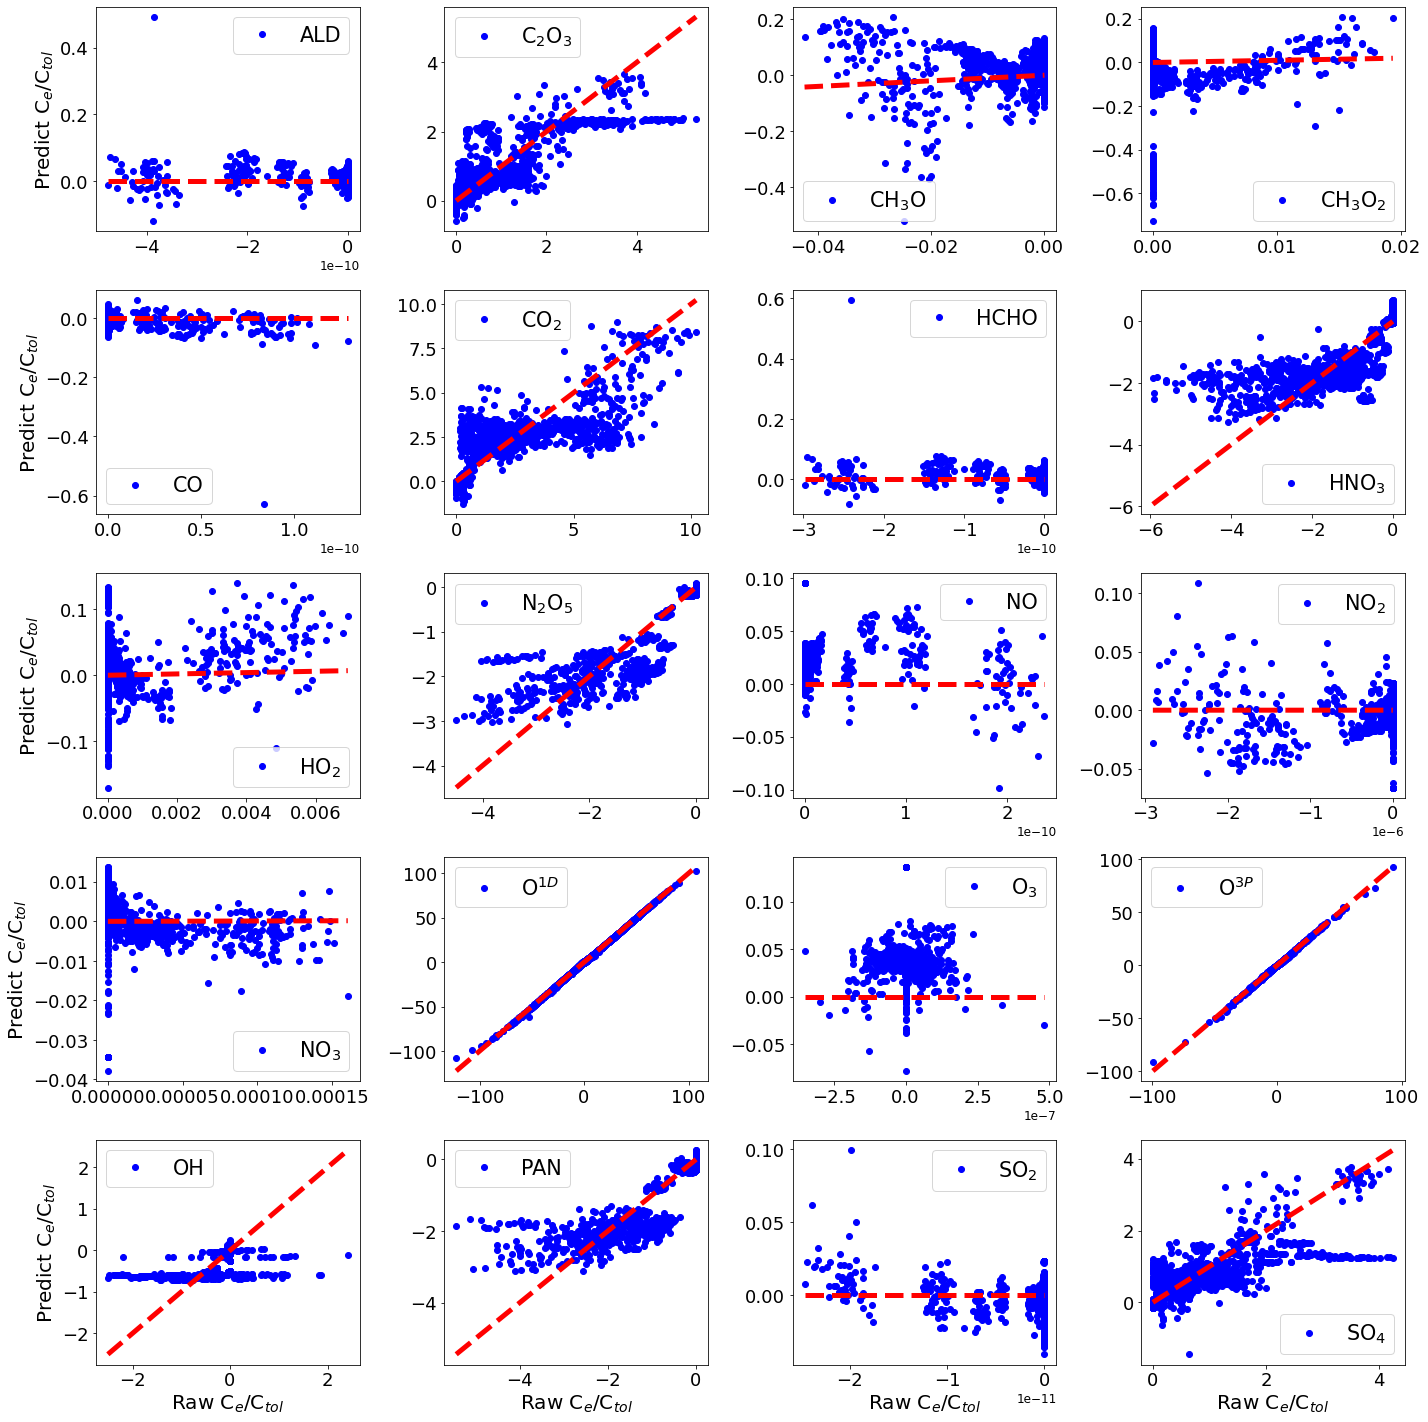

In [8]:
x = model_r([c_train,h_train.reshape(-1,1)]).numpy()
y = y_train

s = len(species)
nrows,ncols = 5,4
fig = plt.figure(figsize=(20, 20))
for i in range(s):
    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.plot(y[:,i],x[:,i],'bo',label=spec[i])
    a = np.linspace(np.min(y[:,i]),np.max(y[:,i]),10)
    ax.plot(a,a,'r--',linewidth=5)
    ax.tick_params(labelsize=18)
    if i>15:
        plt.xlabel('Raw C$_e$/C$_{tol}$',fontsize=20)
    if np.mod(i,4)==0:
        plt.ylabel('Predict C$_e$/C$_{tol}$',fontsize=20)
    plt.legend(fontsize='xx-large')
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_train_cect-4.png',dpi=300)

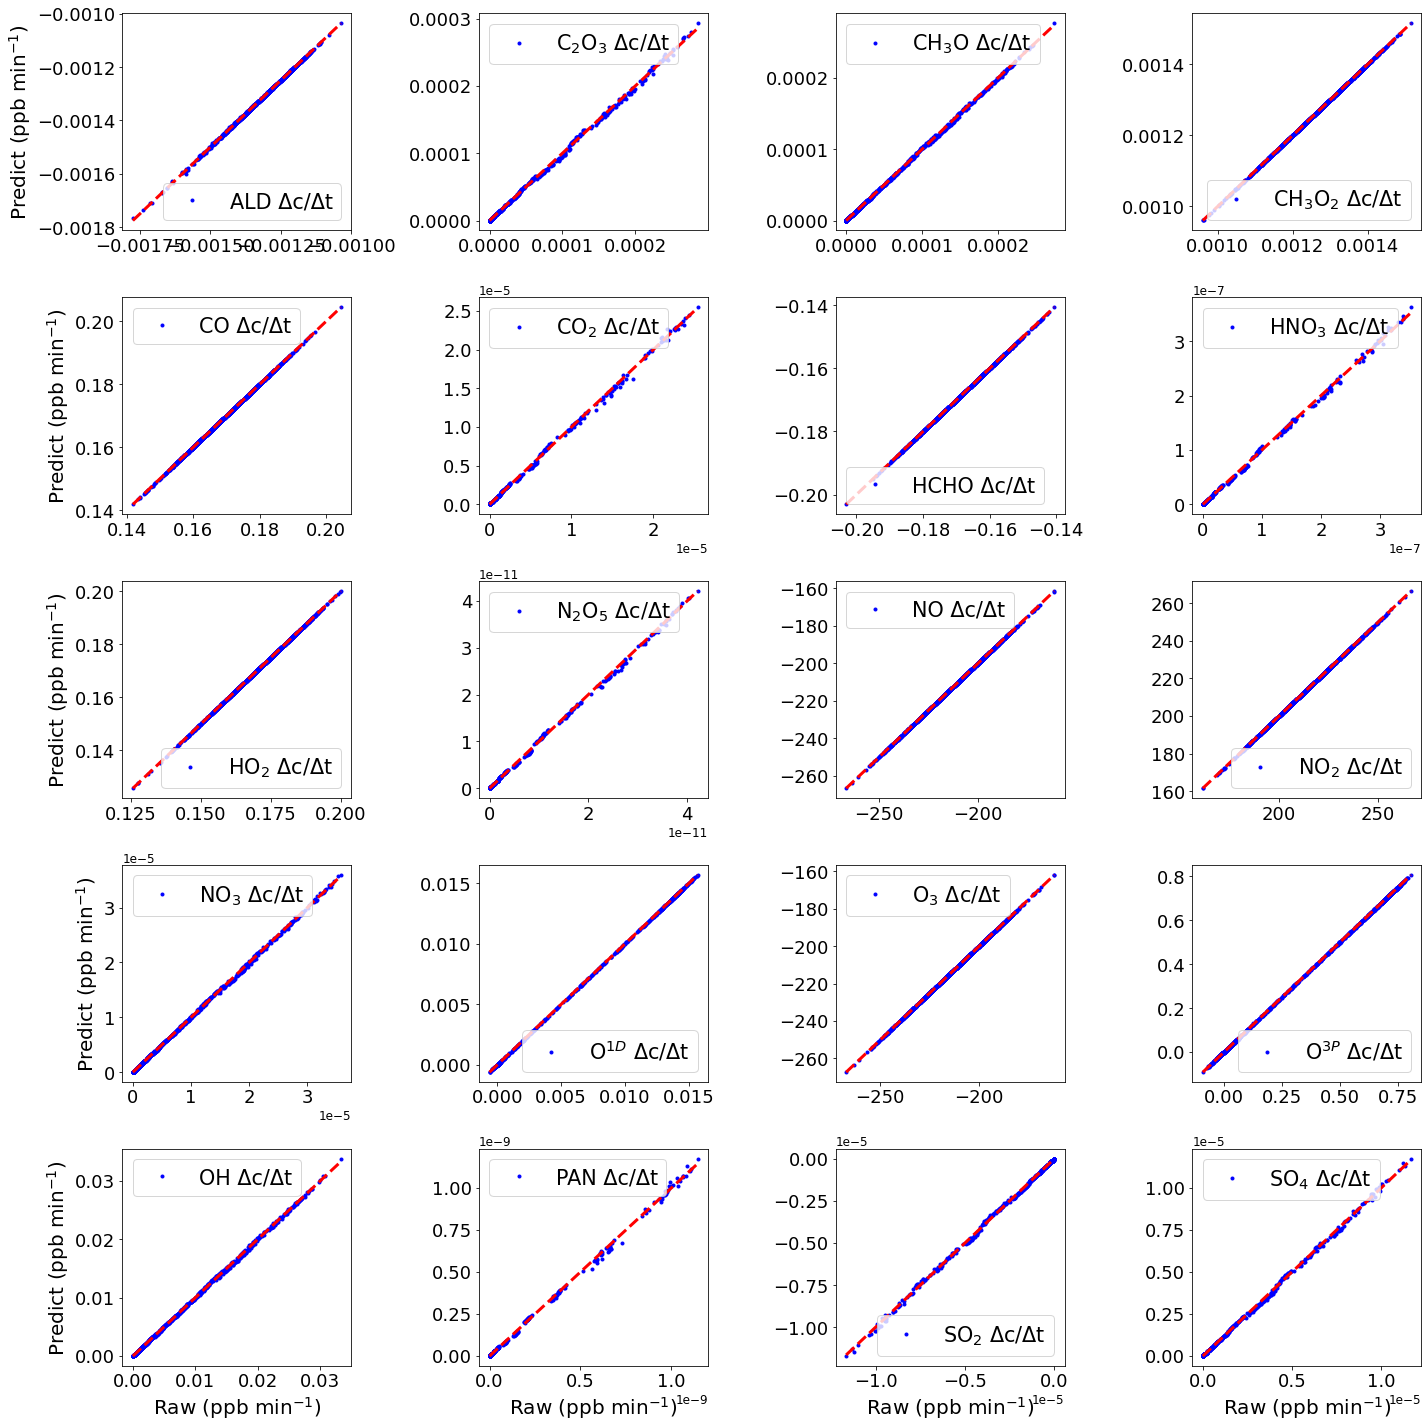

In [9]:
b = []
for i in range(Craw.shape[1]):
    b.append(ODEfcn(0,Craw[:,i],**ODEargs))
b = np.vstack(b)*1000
x = model_c([Craw.T,Hraw.reshape(-1,1)]).numpy()*1000*maxDyDt
y = DyDt*1000

s = len(species)
nrows,ncols = 5,4
fig = plt.figure(figsize=(20, 20))
for i in range(s):
    ax = fig.add_subplot(nrows,ncols,i+1)
#     ax.plot(y[:,i],b[:,i],'co',label=spec[i]+' dc/dt')
    ax.plot(y[:,i],x[:,i],'b.',label=spec[i]+' Δc/Δt')
    a = np.linspace(np.min(y[:,i]),np.max(y[:,i]),10)
    ax.plot(a,a,'r--',linewidth=3)
    ax.tick_params(labelsize=18)
    if i>15: plt.xlabel('Raw (ppb min$^{-1}$)',fontsize=20)
    if np.mod(i,4)==0: plt.ylabel('Predict (ppb min$^{-1}$)',fontsize=20)
    plt.legend(fontsize='xx-large')
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_train_dcdt-4.png',dpi=300)